## Imports

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import json
import models
import datasets
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
EXAMINE = 0

## Load Training Data

In [3]:
torch.manual_seed(22)

blog_posts_data_dir = "data/blogs/json-data/"
train_file_name = "train.json"
test_file_name = "test.json"

training_set = datasets.BlogPostDataset(blog_posts_data_dir, train_file_name)

# Map each word to a unique int value
word_to_int = {}
for instance in training_set:
    for word in instance["post"]:
        if word not in word_to_int:
            word_to_int[word] = len(word_to_int)

def prepare_sequence(seq, word_to_int):
    ints = [word_to_int[w] for w in seq]
    return torch.tensor(ints, dtype = torch.long)


ooh shiny new commenting!


## Find Key Metrics

In [76]:
samples_count = len(training_set)

categories_count = len(training_set[0]["age"])

samples_per_class = {0 : 0, 1 : 0, 2 : 0}
for instance in training_set:
    for i, a in enumerate(instance["age"]):
        if a == 1:
            samples_per_class[i] += 1
            break

median_words_per_sample = np.median([len(instance["post"]) for instance in training_set])
 

121.0


In [78]:
print("Number of Samples:", samples_count)
print("Number of Categories:", categories_count)
print("Samples per Class:", samples_per_class)
print("Median Words per Sample:", median_words_per_sample)
print("Samples to Words Per Sample Ratio:", samples_count / median_words_per_sample)

Number of Samples: 526812
Number of Categories: 3
Samples per Class: {0: 177940, 1: 250672, 2: 98200}
Median Words per Sample: 121.0
Samples to Words Per Sample Ratio: 4353.818181818182


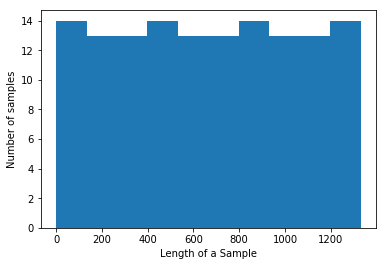

In [79]:
plt.hist(list(length_distribution.keys()))
plt.xlabel("Length of a Sample")
plt.ylabel("Number of samples")
plt.show()

## Train the Model

In [5]:

# Train the model
EMBEDDING_DIM = 32
HIDDEN_DIM = 15
NUM_AGE_GROUPS = 3
model = models.BasicLSTMAgeClassifier(EMBEDDING_DIM, len(word_to_int), HIDDEN_DIM, NUM_AGE_GROUPS)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.1)

# WORDS DON'T HAVE AGES, SENTENCES HAVE AGES. I figured this out when I was high. Just thought
# where did the "4" in the prediction tensor's shape come from?
# I need to treat myself like a student and write out my thought process as I'm trying to solve
# a problem. I need to ask myself questions.

# See what the scores are before training
with torch.no_grad():
    inputs = prepare_sequence(training_set[EXAMINE]["post"], word_to_int)
    group_scores = model(inputs)
    print(group_scores)

for epoch in range(300):
    for instance in training_set[ : 4000]:
        
        # Zero-out the gradients
        model.zero_grad()

        # Zero-out hidden state from previous instance
        model.hidden = model.init_hidden()

        sentence_in = prepare_sequence(instance["post"], word_to_int)
        group = torch.tensor(instance["age"], dtype = torch.long).unsqueeze(0)
        print("Group Shape:", group.shape)
        print("Group:", group)

        group_scores = model(sentence_in)
        print("Group Scores Shape:", group_scores.shape)
        print("Group Score Training:", group_scores)
        
        loss = loss_function(group_scores, group)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_set[EXAMINE]["post"], word_to_int)
    group_scores = model(inputs)
    print(group_scores)

# TODO: Save the model

<class 'torch.Tensor'>
Group Scores Length: 4
tensor([[-0.8814, -1.1860, -1.2717],
        [-0.9588, -1.1227, -1.2337],
        [-0.9526, -1.1911, -1.1700],
        [-0.9368, -1.1588, -1.2233]])
Group Shape: torch.Size([1, 3])
Group: tensor([[ 1,  0,  0]])
<class 'torch.Tensor'>
Group Scores Length: 4
Group Scores Shape: torch.Size([4, 3])
Group Score Training: tensor([[-0.8814, -1.1860, -1.2717],
        [-0.9588, -1.1227, -1.2337],
        [-0.9526, -1.1911, -1.1700],
        [-0.9368, -1.1588, -1.2233]])


ValueError: Expected input batch_size (4) to match target batch_size (1).